In [1]:
# kd crossover，close < ema 8, ema 8 < ema 18, ema 18 < 38, take profit 4 atr, stop loss 3 atr
# 1651366861000
# ! conda install -c conda-forge ta --yes

In [2]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1651366861000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:

sl_atr = 0.05
tp_atr = 13.5
kd_dir = 'Any'

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    raw_df = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        raw_df = pd.concat([raw_df, out], axis = 0)
    
    raw_df = raw_df[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    raw_df = raw_df.astype(convert_dict)
    
    raw_df['Close_Time'] = pd.to_datetime(raw_df['Close_Time'], unit = 'ms')
    raw_df['Close_Time'] = raw_df['Close_Time'] + pd.Timedelta(hours=timezone)
    raw_df['Close_Time'] = raw_df['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    raw_df = raw_df.reset_index(drop=True)
    
    return raw_df

In [6]:
raw_df = get_historical(symbol, interval, start_time, end_time, step)
print(raw_df)

                Close_Time     Open    Close     High      Low      Volume
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383
...                    ...      ...      ...      ...      ...         ...
32593  2023-04-05 22:59:59  1899.76  1897.45  1904.00  1897.24   6291.8980
32594  2023-04-05 23:14:59  1897.46  1901.17  1901.52  1882.31  24319.6518
32595  2023-04-05 23:29:59  1901.16  1901.00  1902.95  1894.85  13662.3337
32596  2023-04-05 23:44:59  1901.01  1901.77  1902.00  1896.49   6510.3919
32597  2023-04-05 23:59:59  1901.77  1901.31  1905.26  1901.16   3571.6793

[32598 rows x 6 columns]


In [7]:
df = raw_df.copy()

In [8]:
def check_cross(df, kd_dir):
    up = df['slow_k'] > df['slow_d']
    down = df['slow_k'] < df['slow_d']
    if kd_dir == 'Up':
        return up.diff() & up
    if kd_dir == 'Any':
        return up.diff()
    if kd_dir == 'Down':
        return down.diff() & down


def indicators(df, kd_dir):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kd_df = pd.DataFrame()
    kd_df[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kd_df[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kd_df[str(kd_int) + '-Low'])*100/(kd_df[str(kd_int) + '-High'] - kd_df[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
# kd cross
    df['kd_cross'] = check_cross(df, kd_dir)

In [9]:
indicators(df, kd_dir)
print(df)

                Close_Time     Open    Close     High      Low      Volume  \
0      2022-05-01 09:29:59  2738.40  2738.36  2742.95  2734.26   3623.6520   
1      2022-05-01 09:44:59  2738.36  2768.97  2772.00  2725.40  11211.8237   
2      2022-05-01 09:59:59  2768.97  2770.25  2777.36  2762.01   9232.8878   
3      2022-05-01 10:14:59  2770.26  2773.27  2776.22  2765.86   4203.3607   
4      2022-05-01 10:29:59  2773.27  2771.35  2780.62  2769.65   5154.4383   
...                    ...      ...      ...      ...      ...         ...   
32593  2023-04-05 22:59:59  1899.76  1897.45  1904.00  1897.24   6291.8980   
32594  2023-04-05 23:14:59  1897.46  1901.17  1901.52  1882.31  24319.6518   
32595  2023-04-05 23:29:59  1901.16  1901.00  1902.95  1894.85  13662.3337   
32596  2023-04-05 23:44:59  1901.01  1901.77  1902.00  1896.49   6510.3919   
32597  2023-04-05 23:59:59  1901.77  1901.31  1905.26  1901.16   3571.6793   

             ema_8       ema_18       ema_38        atr        

In [10]:
def conditions(df):

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] <= df['ema_38']


    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_entry'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_entry'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_entry
0,2022-05-01 09:29:59,2738.40,2738.36,2742.95,2734.26,3623.6520,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2022-05-01 09:44:59,2738.36,2768.97,2772.00,2725.40,11211.8237,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2022-05-01 09:59:59,2768.97,2770.25,2777.36,2762.01,9232.8878,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2022-05-01 10:14:59,2770.26,2773.27,2776.22,2765.86,4203.3607,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2022-05-01 10:29:59,2773.27,2771.35,2780.62,2769.65,5154.4383,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32593,2023-04-05 22:59:59,1899.76,1897.45,1904.00,1897.24,6291.8980,1903.684034,1907.740690,1907.555298,9.340969,38.988849,14.944891,16.109347,True,True,True,True,False,False,False
32594,2023-04-05 23:14:59,1897.46,1901.17,1901.52,1882.31,24319.6518,1903.125360,1907.049038,1907.227847,10.045900,43.218619,31.086204,21.763774,True,True,True,True,True,True,False
32595,2023-04-05 23:29:59,1901.16,1901.00,1902.95,1894.85,13662.3337,1902.653058,1906.412298,1906.908470,9.906907,43.071662,30.806000,25.612365,False,False,True,True,True,False,True
32596,2023-04-05 23:44:59,1901.01,1901.77,1902.00,1896.49,6510.3919,1902.456823,1905.923635,1906.644959,9.592842,44.000478,32.075161,31.322455,False,False,True,True,True,False,False


In [12]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']
open_val = entry_df['Open']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_entry'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] >= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'Low'] <= take_profit):
        entry_df.at[index, 'position'] = 'Buy'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan


entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_entry'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


                Close_Time     Open    Close     High      Low      Volume  \
43     2022-05-01 20:14:59  2756.79  2760.11  2779.42  2753.50   7149.9979   
44     2022-05-01 20:29:59  2760.11  2764.59  2770.00  2754.94   3243.8298   
45     2022-05-01 20:44:59  2764.60  2763.63  2766.88  2759.27   1897.6580   
52     2022-05-01 22:29:59  2760.67  2761.54  2767.40  2760.66   2904.5273   
53     2022-05-01 22:44:59  2761.54  2765.94  2766.45  2758.07   3610.2701   
...                    ...      ...      ...      ...      ...         ...   
32428  2023-04-04 05:44:59  1782.81  1790.60  1790.60  1781.17   4912.3254   
32594  2023-04-05 23:14:59  1897.46  1901.17  1901.52  1882.31  24319.6518   
32595  2023-04-05 23:29:59  1901.16  1901.00  1902.95  1894.85  13662.3337   
32596  2023-04-05 23:44:59  1901.01  1901.77  1902.00  1896.49   6510.3919   
32597  2023-04-05 23:59:59  1901.77  1901.31  1905.26  1901.16   3571.6793   

             ema_8       ema_18       ema_38        atr  ...   

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Short') |
              (pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)

for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Buy':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Short':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Short':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Short':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Buy' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)

        
# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Short':
        pos = pos.drop(index)
    else:
        break


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee


# 損益
leverage = 10
ttl_profit = pos.amt.sum() - ttl_fee


# 計算獲利/虧損次數
agg_amts = []

for i in range(len(pos) - 1, -1, -1):
    # check if the current position is 'Stop' or 'Buy'
    if pos.loc[i, 'position'] in ['Stop', 'Buy']:
        
        # if it is, initialize a variable to store the aggregated amount
        total_amt = pos.loc[i, 'amt'] - np.absolute(pos.loc[i, 'amt']) * fee
        
        # iterate backwards from the current row until reaching another 'Stop' or 'Buy'
        j = i - 1
        while j >= 0 and pos.loc[j, 'position'] not in ['Stop', 'Buy']:
            total_amt += pos.loc[j, 'amt']
            trading_fee = np.absolute(pos.loc[j, 'amt']) * fee
            total_amt -= trading_fee
            j -= 1
        
        # add the aggregated amount to the list
        agg_amts.append(total_amt)

agg_amts.reverse()
    

# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Short':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Buy', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if position_amt_sum > max_profit:
            max_profit = position_amt_sum
            
        if position_amt_sum < max_loss:
            max_loss = position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass


# 最大部位
profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)


# 勝率
wins = 0
loses = 0

for trade in agg_amts:
    if trade > 0:
        wins += 1
    elif trade < 0:
        loses += 1

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)


# 結果
result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')



     Profit      Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  16686.38  5863.42      929.94     -54.3         13      19440.23  858.34%   

  Win_Rate  
0   28.27%  

               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-05-01 20:29:59  2760.11  2764.59  2770.00  2754.94  2762.732881   
1     2022-05-01 20:44:59  2764.60  2763.63  2766.88  2759.27  2762.932241   
2     2022-05-01 22:44:59  2761.54  2765.94  2766.45  2758.07  2763.096583   
3     2022-05-01 23:14:59  2760.18  2768.06  2770.92  2760.18  2763.697192   
4     2022-05-01 23:29:59  2768.07  2797.30  2798.01  2764.73  2771.164483   
...                   ...      ...      ...      ...      ...          ...   
5648  2023-04-04 01:44:59  1796.99  1800.64  1806.86  1795.13  1797.538241   
5649  2023-04-04 05:29:59  1780.99  1782.81  1788.32  1779.20  1792.295845   
5650  2023-04-04 05:44:59  1782.81  1790.60  1790.60  1781.17  1791.918991   
5651  2023-04-05 23:29:59  1901.

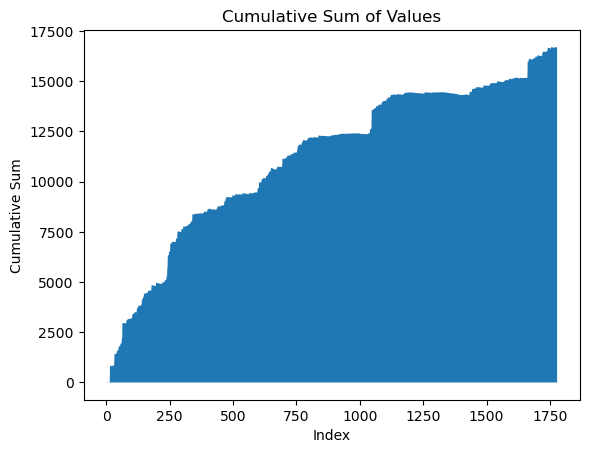

[-3.298679149999687, -8.392295199999513, 15.827084549999395, 12.461229549999498, -2.009458200002106, -14.733644950003526, -18.06931550000359, -21.456217800003532, -13.595516600003606, -0.7910961000037346, 18.446357749996533, 15.043647399996072, 11.715245199996058, 8.379281349996052, 5.071420349996091, 826.3308532999986, 825.682163799998, 821.9687664499983, 818.3427334499984, 819.4566824499987, 816.1777208499987, 812.9273554999985, 812.5931723999978, 858.5428201499983, 854.8872041499985, 823.344165049998, 811.119046749998, 807.5236711499981, 805.264738149998, 852.1582600499959, 846.8514146499966, 838.8210353999966, 1058.9789067499976, 1408.5291685499917, 1419.8664688999927, 1416.6587318499928, 1436.2809137499928, 1419.915188299993, 1420.8617594499926, 1432.4784395999923, 1429.067023599992, 1442.0914514999913, 1579.6227975499914, 1576.3154128499914, 1557.2747425999912, 1558.1190392499911, 1625.1907516499907, 1621.7997239999906, 1635.4091729499908, 1696.242929499989, 1774.1922894999882, 1

In [14]:
cumulative_values = []
cumulative_sum = 0
for value in agg_amts:
    cumulative_sum += value
    cumulative_values.append(cumulative_sum)

plt.fill_between(range(len(cumulative_values)), cumulative_values, 0)

plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.title('Cumulative Sum of Values')

plt.show()

print(cumulative_values)

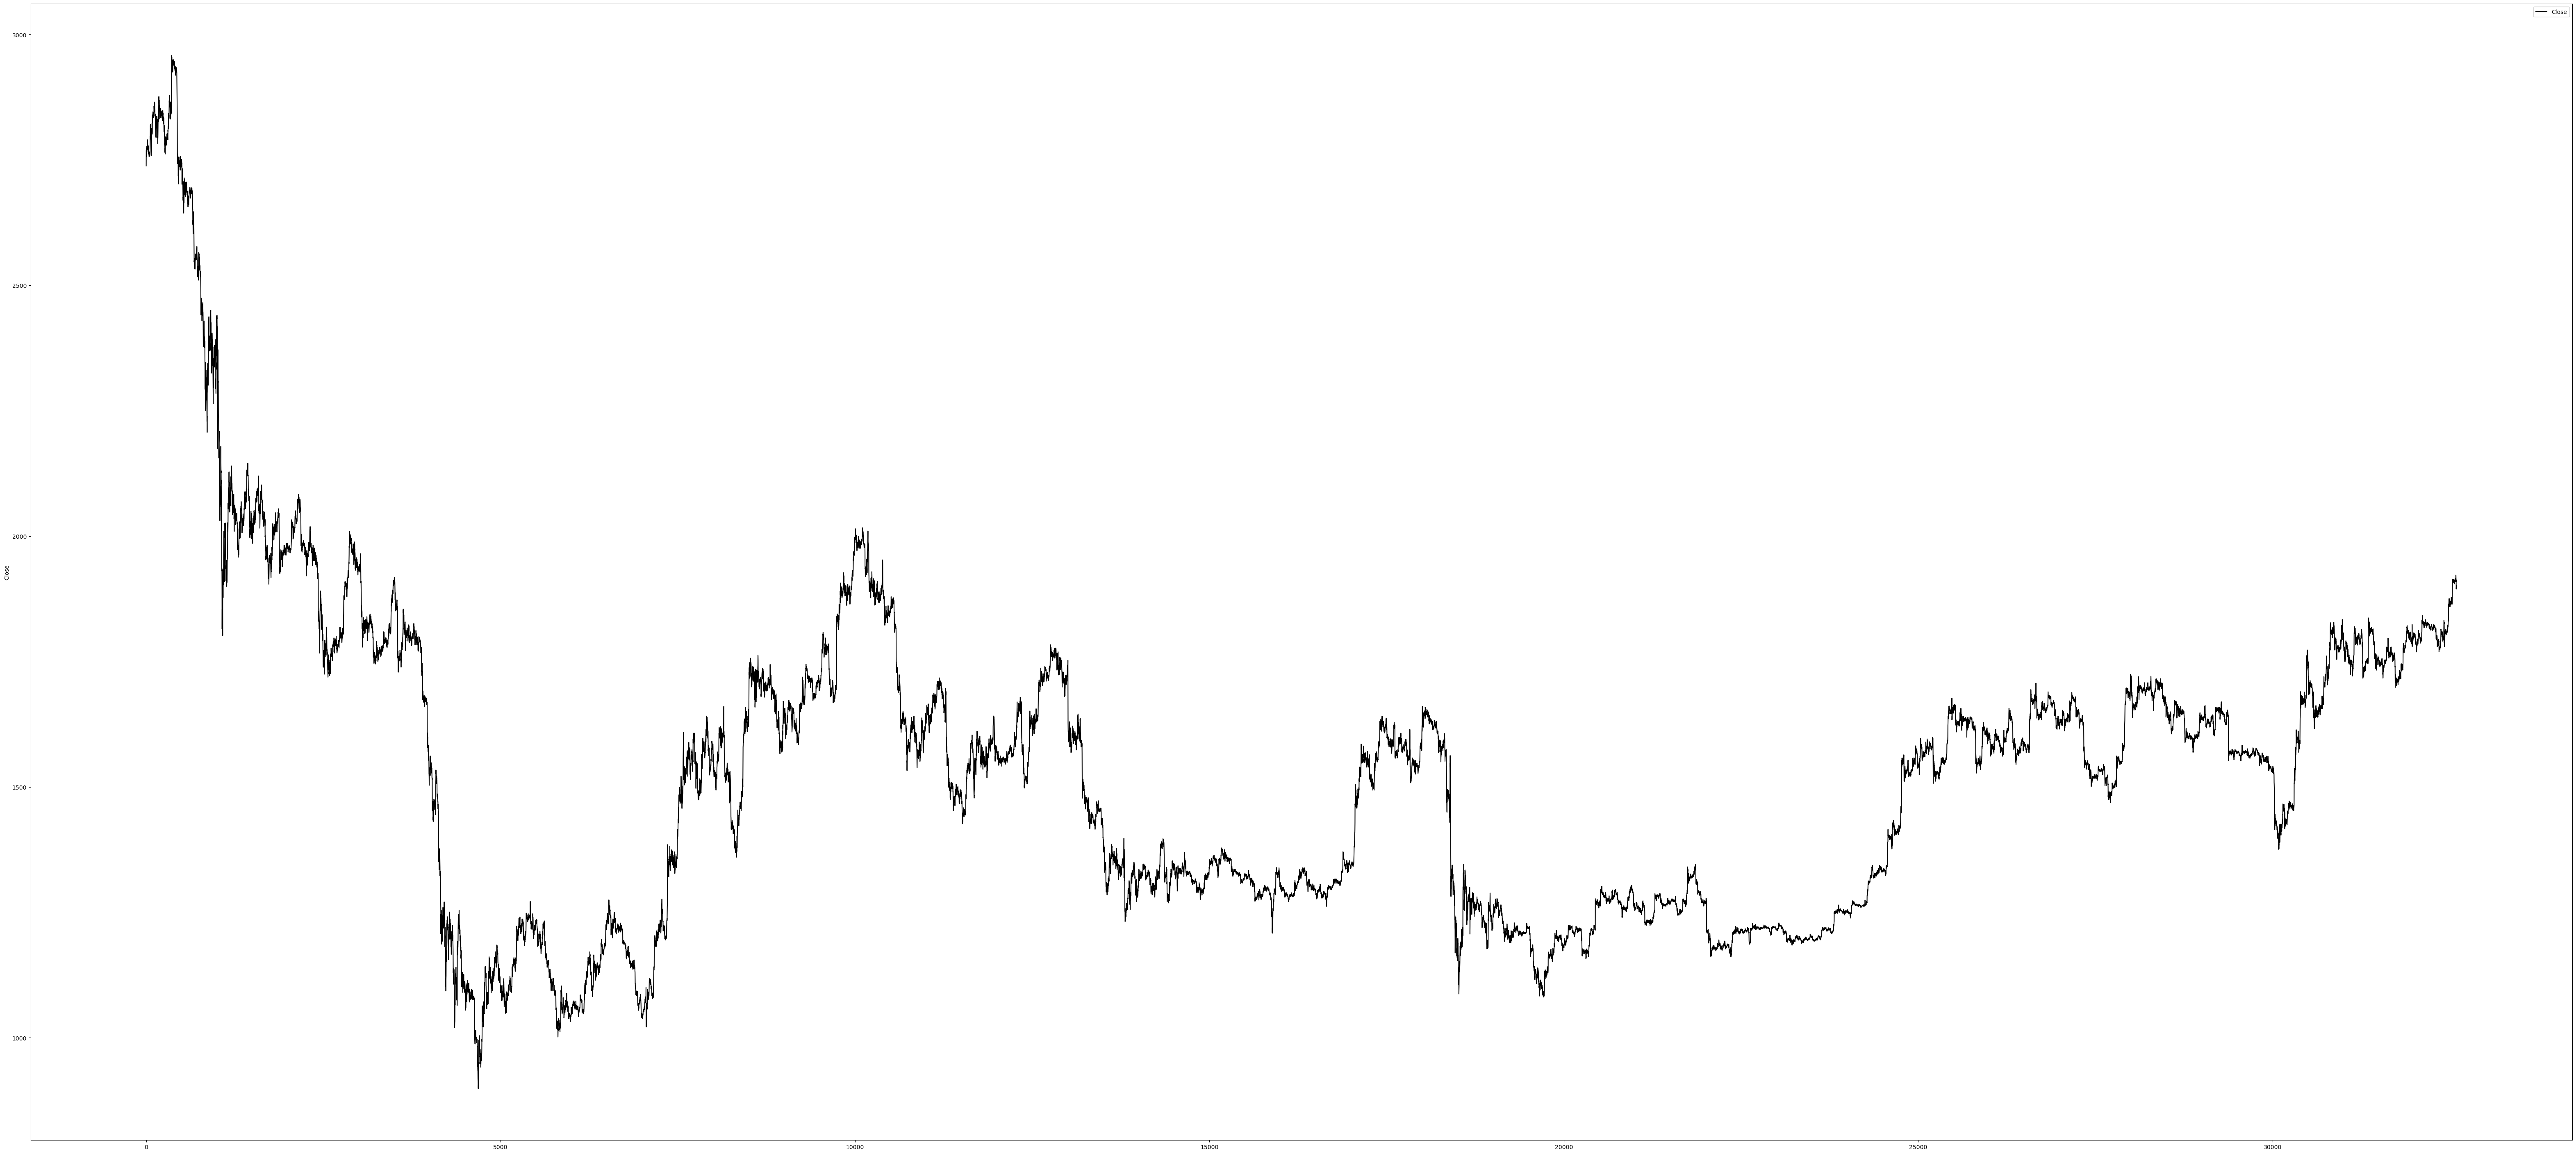

In [15]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.position[i] == 'Buy':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.position[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()